#Stock Price Forecasting

First, we'll import the relevant libraries for our crypto bot. Most notably, the Pandas Datareader is vital for using the finance API.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import os
!pip install pandas_datareader --upgrade

#NN work best with data preprocessed to values between 0-1 or -1-1, so use this.
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
stock = 'MRNA'
fiat = 'USD'

In [7]:
start = dt.datetime(2014,1,15)
end = dt.datetime.now()

#Read crypto data from API

data = web.DataReader(f'{stock}-{fiat}', 'yahoo', start, end)

In [8]:
#check data
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-08,169.774994,159.625000,159.699997,169.300003,216.0,169.300003
2020-12-09,170.475006,149.800003,169.300003,156.175003,2544.0,156.175003
2020-12-10,158.500000,149.000000,156.175003,155.300003,793.0,155.300003
2020-12-11,163.125000,151.850006,155.300003,160.000000,1040.0,160.000000
2020-12-12,160.000000,157.574997,160.000000,157.600006,3152.0,157.600006


Next we'll be using a MinMax Scaler to normalize the data. The Formula used in MinMax Scaling is shown below. 

$$Xsc=\dfrac{X−Xmin}{Xmax−Xmin}.$$

The MinMax Scaler works by scaling data to a fixed range, generally zero to one (as we're using here). This will give us much smaller standard deviations than standardization, which will supress the effects of outliers on our analysis of the stock.

After this, we'll set the number of days out we're planning to predict based on.


We'll then set the number of days we want to predict in the future, let's keep it around 90.

In [9]:
#Scale everything within 0-1 range as said earlier.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#Decide how many days to base prediction on, older = more conservative.
prediction_days = 180
future_day = 90

x_train, y_train = [], []

We'll next fill our training data by iteration over our prediction days, and appending the scaled data as we do so. 

In [10]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Now, we'll construct a Neural Network using a sequential model. Unlike other models, a sequential model works by stacking neurons on top of each other, and activating them one at a time (the default operation being a linear activation function.

The sequential model uses this formula.

$$h(x)=
\sum_{i=1}^n
(θ ix i)$$

𝑥₁ is our number of flats, and 0₁ represents our initial random weight. Our bias is 𝑥₀, and our initial random weight is 0₀.
​



The next aspect of the model is our loss function, which gives us a value showing how well our model fits the training data. Our goal is to minimize the value of the loss function by returning by adjusting the weights accordingly.

$$h(x)=θ₀+θ₁x₁$$

 The last model is the Mean Squared Error (MSE), which we compute using this formula.

$$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2MSE= n1∑ 
i=1n(Yi−Y^i)2$$

The MSE is meant to give us the averaged squared difference between the actual value and the estimated value. Our number of predictions, 𝑛, taken from 𝑛 amounts of data points give us. 𝑌 is our predicted values, and Ŷ is our predicted values.

Within our sequential model, we'll implement Long short-term memory (LSTM). LSTM is a recurrent neural network (RNN). LSTM has feedback connections, unlike standard neural networks, which are feeed forward. LSTMs have proven invaluable in working with time series data, especially market forecasting, with most top performing models using LSTM to some degree.

\begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}h_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}h_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}h_{t-1}+b_{o})\\{\tilde {c}}_{t}&=\sigma _{c}(W_{c}x_{t}+U_{c}h_{t-1}+b_{c})\\c_{t}&=f_{t}\circ c_{t-1}+i_{t}\circ {\tilde {c}}_{t}\\h_{t}&=o_{t}\circ \sigma _{h}(c_{t})\end{aligned}

In the above formula, the lowercase variables represent vectors. Matrices Wᵩ and Uᵩ contain, respectively, the weights of the input and recurrent connections, where the subscript ᵩ can either be the input gate *i*, output gate *o*, the forget gate *f* or the memory cell *c*, depending on the activation being calculated. In this section, we are thus using a "vector notation". 

We'll also introduce a dropout function to stop overfitting. For model estimation, we minimize a loss function by looking at the ordinary least square loss.

$$E_{D} = \dfrac{1}{2} (t-\sum_{i=1}^n \delta_{t}^i w_{i} I_{i})^2$$


Here, the dropout rate is 𝛿, with 𝛿 ~ Bernoulli(p). 

The backpropagation for network training uses a gradient descent approach. To do that, we'll first look at the gradient of the dropout network.

$$\frac{\partial E_{D}}{\partial w_{i}} = -t\delta_{i}I_{i}+w_{i}^2I_{i}^2+ \sum_{j=1,j\neq1}^2 w_{j}\delta_{i}\delta_{j}I_{i}I_{j}$$

To find the relationship between this gradient and the gradient of the regular network, we can make w’ = p*w in the normal for an ordinary least square loss. Therefore,


$$E_{N} = \dfrac{1}{2} (t-\sum_{i=1}^n p_{i} w_{i} I_{i})^2$$

With the derivitive of this we find,


$$\frac{\partial E_{N}}{\partial w_{i}} = -tp_{i}I_{i}+w_{i}p_{i}^2I_{i}^2 + \sum_{j=1,j\neq1}^n w_{j}p_{i}p_{j}I_{i}I_{j}$$

Finally, we have the gradient of the dropout network,


$$E[\frac{\partial E_{D}}{\partial w_{i}}] = -tp_{i}I_{i}+w_{i}p_{i}^2I_{i}^2 + w_{j}Var(\delta_{i}I_{i})^2+\sum_{j=1,j\neq1}^n w_{j}p_{i}p_{j}I_{i}I_{j}$$
$$=$$

$$=\frac{\partial E_{N}}{\partial w_{i}} + w_{i}Var(\delta_{i})I_{i}^2$$

$$=\frac{\partial E_{N}}{\partial w_{i}} + w_{i}p_{i}(1-p_{i})I_{i}^2$$


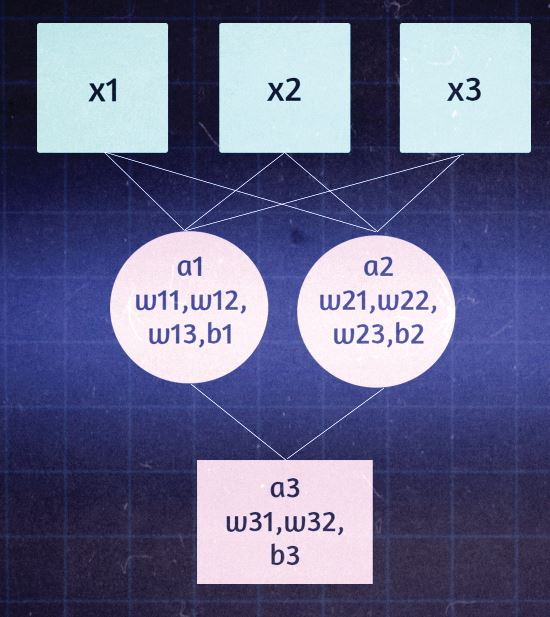

The final layer in our Neural Network will be a dense layer. What this means is that, unlike our dropout laters, each neuron will be connected to each neuron in the previous layer. 

$$a1=x1*w11+x2*w12 + x3*w13+b1$$
$$a2=x1*w21+x2*w22 + x3*w23+b2$$

$$a3=a1*w31+as*w32+b3$$

a1 and a2 are the neurons within the dense layer, and a3 is the neuron of the output layer. x1, x2, and x3 are the input neurons on the input layer. Each w is a weight, and each b is a bias in our neural network.


For gradient descent optimization, we'll use Adaptive Moment Estimation (ADAM). It's a combination of two gradient descent optimization techniques, and accelerates the gradient descent by taking using the ‘exponentially weighted average’ of each gradient. This is faster and more PC efficient.

$$wt+1 = wt-\alpha m_{t}$$

where,

$$m_{t} \beta_{1}m_{t-1}+(1 -\beta)[\frac{\delta L}{\delta w_{t}}]v_{t}=\beta_{2} v_{t-1}+(1-\beta_{2})[\frac{\delta L}{\delta w_{t}}]^2$$




In [11]:
#Create NN
#Possibly downgrade Numpy if it doesn't work (1.19.5)

model = tf.keras.Sequential()

#Add LSTM layers

model.add(LSTM(units = 50, 
               return_sequences = True, 
               input_shape = (x_train.shape[1],1)
               ))

model.add(tf.keras.layers.Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(LSTM(units = 50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, 
          y_train, 
          epochs = 25,
          batch_size = 32)

Epoch 1/25
14/14 [==============================] - 11s 310ms/step - loss: 0.0708
Epoch 2/25
14/14 [==============================] - 4s 303ms/step - loss: 0.0443
Epoch 3/25
14/14 [==============================] - 4s 284ms/step - loss: 0.0414
Epoch 4/25
14/14 [==============================] - 4s 284ms/step - loss: 0.0413
Epoch 5/25
14/14 [==============================] - 4s 290ms/step - loss: 0.0416
Epoch 6/25
14/14 [==============================] - 4s 288ms/step - loss: 0.0393
Epoch 7/25
14/14 [==============================] - 4s 296ms/step - loss: 0.0372
Epoch 8/25
14/14 [==============================] - 4s 289ms/step - loss: 0.0352
Epoch 9/25
14/14 [==============================] - 4s 290ms/step - loss: 0.0317
Epoch 10/25
14/14 [==============================] - 4s 286ms/step - loss: 0.0266
Epoch 11/25
14/14 [==============================] - 4s 284ms/step - loss: 0.0197
Epoch 12/25
14/14 [==============================] - 4s 291ms/step - loss: 0.0152
Epoch 13/25
14/14 [=====

Finally, we can test our model. To do this, we'll specify a time frame for the testing data, then we'll compare the results of our model to the real results.

23/23 [==============================] - 4s 164ms/step


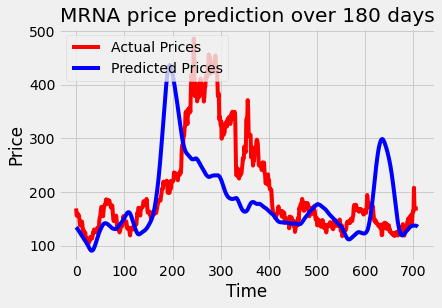

In [14]:
# Testing the Model

#set start day for test data
test_start = dt.datetime(2020,1,1)
#set end day for the test
test_end = dt.datetime.now()

test_data = web.DataReader(f'{stock}-{fiat}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

##get the total length of the data set with all the values, and subtract the amount of days you're predicting. That way, we can use the prediction as input and get the values after the time of the prediction only.
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
#reshape model to long form
model_inputs = model_inputs.reshape(-1,1)
#Use fit transform to fit it to our MinMax scaler
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.style.use('fivethirtyeight')
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(prediction_prices, color='blue', label='Predicted Prices')
plt.title(f'{stock} price prediction over 180 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

#Closing thoughts: 

Predicting stock requires constant tinkering, a good API, and a solid understanding of deep learning techniques. What was a great model yesterday could become unwieldy tomorrow. That being said, this AI seems to follow trends fairly accurately.